<center><b>Task 1. Image classification + OOP</b></center>

In this task, you need to use a publicly available simple MNIST dataset and build 3 classification
models around it. It should be the following models:

1) Random Forest;
2) Feed-Forward Neural Network;
3) Convolutional Neural Network;

Each model should be a separate class that implements MnistClassifierInterface with 2 abstract methods - train and predict. Finally, each of your three models should be hidden under

another MnistClassifier class. MnistClassifer takes an algorithm as an input parameter. Possible values for the algorithm are: cnn, rf, and nn for the three models described above.


In [1]:
!pip install requirements.txt

HINT: You are attempting to install a package literally named "requirements.txt" (which cannot exist). Consider using the '-r' flag to install the packages listed in requirements.txt


ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt
You should consider upgrading via the 'C:\Users\user\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


MnistClassifier Interface that used for each model.

In [2]:
from abc import ABC, abstractmethod

class MnistClassifierInterface(ABC):
    """
    MnistClassifierInterface includes 2 methods for train model and prediction.
    It inherited by CNNClassifier, RFClassifier, FFNNClassifier
    """
    @abstractmethod
    def train(self,x_train,y_train):
        pass

    @abstractmethod
    def predict(self,x_test):
        pass



<b> First model : Random forest</b>

After creation of interface, now we can create each of models, which will be separated in classes. The first model will be Random Forest.

Model was created with sklearn and trained using KFold algorithm separating dataset into 10 folds. During the fold, for searching the best parameters of model, i used the RandomizedSearchCV,

where I put parameters and possible values for them. This function will find the best combination of parameters' values. Then, the model will be compared to the accuracy score of the best model that was find at that moment.

Dataset for training and prediction was initialized in file for inference.

In [3]:
from MnistClassifierInterface import MnistClassifierInterface
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

kfold_split=10
class RFClassifier(MnistClassifierInterface):


    """
    Random Forest model
    """


    def __init__(self):

        self.model=RandomForestClassifier()

    def train(self,x_train,y_train,kfold_split=kfold_split):
        self.kfold_split=kfold_split

        self.model.fit(x_train, y_train)
        # y_pred=self.model.predict(x_train)#evaluate prediction on default settings
        best_accuracy_score=0
            # accuracy_score(y_train, y_pred) #calculate and set as start point the model on default settings
        # best_model
        accuracy_train_arr, accuracy_test_arr = [], []
        kf = KFold(n_splits=self.kfold_split)


        for i, (train_index, test_index) in enumerate(kf.split(x_train)):

            X_train_fold, X_test_fold = x_train[train_index],x_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]


            distributions = {
                'n_estimators': [10, 50, 100, 200, 300],
                'max_depth': [9, 15, 20, 30],
                'criterion' : ['gini','entropy'],
                'min_samples_leaf': [1,5,10,20,50,100],
                'warm_start': [True,False],
                'bootstrap': [True, False],
                'min_samples_leaf': [1,5,10,20,50,100],
                'max_leaf_nodes': [5,10,20,50,100,200],

            }

            clf = RandomizedSearchCV(self.model, distributions,
                                     verbose=0, scoring='accuracy')
            search = clf.fit(X_train_fold, y_train_fold)

            model = search.best_estimator_

            print('Search is finished. Best parameters: \n')
            print(search.best_params_)


            y_pred = model.predict(X_train_fold)
            accuracy_train = accuracy_score(y_train_fold, y_pred)

            y_pred = model.predict(X_test_fold)
            accuracy_test = accuracy_score(y_test_fold, y_pred)

            accuracy_train_arr.append(accuracy_train)
            accuracy_test_arr.append(accuracy_test)

            print(f'\n FOLD-{i}. Accuracy train: {accuracy_train}, Accuracy test: {accuracy_test} \n')


            if accuracy_test > best_accuracy_score:
                best_accuracy_score = accuracy_test
                best_model = model
                print(f' FOLD-{i}. Model has best score.')

        self.model = best_model


    def predict(self, x_test):
        return self.model.predict(x_test)




<b> Second model : Feedforward neural network</b>

Model was created with keras and tensorflow-directml (to be able to use GPU during model training).  
Architecture of the model consist of: 
* Input of 64 array,

* Dense layers with 128, 256, 128, 64 neurons, respectively, with relu as activation function,

* The final layer is a dense of 10 neurons with softmax as activation function. 
As a loss function for training of this model was used the "sparse_categorical_crossentropy" and Adam as an optimizer. 

Dataset for training and prediction was initialized in file for inference.

In [4]:
import tensorflow.python.keras
from MnistClassifierInterface import MnistClassifierInterface
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,Input
import numpy as np

img_shape=64
train_epochs=50
batch_size=32
class FFNNClassifier(MnistClassifierInterface):

    """
    Feedforward Neural Network model
    """
    def __init__(self):

        input=Input(shape=(img_shape,),dtype=tf.float64)

        dense=Dense(128, activation='relu',name='dense_layer_1')(input)
        dense = Dense(256, activation='relu', name='dense_layer_2')(dense)
        dense = Dense(128, activation='relu', name='dense_layer_5')(dense)
        dense = Dense(64, activation='relu', name='dense_layer_6')(dense)
        output=Dense(10,activation='softmax',name='output_layer')(dense)

        self.model=Model(inputs=input, outputs=output)

        self.model.summary()

    def train(self,x_train,y_train,train_epochs=train_epochs,batch_size=batch_size):
        self.train_epochs = train_epochs  # Initialize train epochs parameter

        self.batch_size = batch_size  # Initialize batch size parameter

        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(x_train, y_train,epochs=self.train_epochs, batch_size=self.batch_size)
    def predict(self,x_test):
        self.model.predict(x_test)
        y_pred = self.model.predict(x_test)
        return np.argmax(y_pred, axis=1)



<b> Third model : Convolution neural network</b>

Model was created with keras and tensorflow-directml (to be able to use GPU during model training).  

Architecture of the model consist of: 
* input of (8,8,1) tensor, 

* Convolution layer with 16 filters of (3,3) size with relu activation, 

* MaxPooling layer, 

* Convoluition layer with 32 filters with relu activation, 

* Flatten layer and then Dense layers with 256, 128, 64 neurons, respectively, with relu as activation function, 

* The final layer is a dense of 10 neurons with softmax as activation function. 

As a loss function for training of this model was used the "sparse_categorical_crossentropy" and Adam as an optimizer. 

Dataset for training and prediction was initialized in file for inference.

In [5]:
from MnistClassifierInterface import MnistClassifierInterface
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,Input, Conv2D,MaxPooling2D
import numpy as np

img_shape=(8,8)
train_epochs=30
batch_size=32

class CNNClassifier(MnistClassifierInterface):
    """
    Convolution Neural Network model
    """

    def __init__(self,img_shape=img_shape):
        self.img_shape=img_shape
        input = Input(shape=(*self.img_shape,1), dtype=tf.float64)

        conv1 = Conv2D(16,(3,3), activation='relu', name='conv_layer_1')(input)
        pool1 = MaxPooling2D((1,1),strides=None, padding="valid", name='maxpool_layer_1')(conv1)
        conv2 = Conv2D(32, (3, 3), activation='relu', name='conv_layer_2')(pool1)
        flatten=Flatten()(conv2)
        dense = Dense(256, activation='relu', name='dense_layer_2')(flatten)
        dense = Dense(128, activation='relu', name='dense_layer_5')(dense)
        dense = Dense(64, activation='relu', name='dense_layer_6')(dense)
        output = Dense(10, activation='softmax', name='output_layer')(dense)

        self.model = Model(inputs=input, outputs=output)

        self.model.summary()

    def train(self,x_train,y_train,train_epochs=train_epochs,batch_size=batch_size):
        self.train_epochs=train_epochs #Initialize train epochs parameter

        self.batch_size=batch_size #Initialize batch size parameter


        x_train=x_train.reshape((x_train.shape[0],*img_shape)) #reshape images
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(x_train, y_train,epochs=self.train_epochs, batch_size=self.batch_size)

    def predict(self,x_test):
        x_test = x_test.reshape((x_test.shape[0], *img_shape))
        self.model.predict(x_test)
        y_pred = self.model.predict(x_test)
        return np.argmax(y_pred, axis=1)



<center><b>Models inference</b></center>


<center><b>Random Forest inference</b></center>


Random Forest model is called
Search is finished. Best parameters: 

{'warm_start': False, 'n_estimators': 50, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}

 FOLD-0. Accuracy train: 0.995579133510168, Accuracy test: 0.9523809523809523 

 FOLD-0. Model has best score.
Search is finished. Best parameters: 

{'warm_start': True, 'n_estimators': 100, 'min_samples_leaf': 10, 'max_leaf_nodes': 50, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}

 FOLD-1. Accuracy train: 0.9787798408488063, Accuracy test: 0.9603174603174603 

 FOLD-1. Model has best score.
Search is finished. Best parameters: 

{'warm_start': False, 'n_estimators': 100, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': False}

 FOLD-2. Accuracy train: 1.0, Accuracy test: 0.9682539682539683 

 FOLD-2. Model has best score.
Search is finished. Best parameters: 

{'warm_start': False, 'n_estimators': 300, 'm

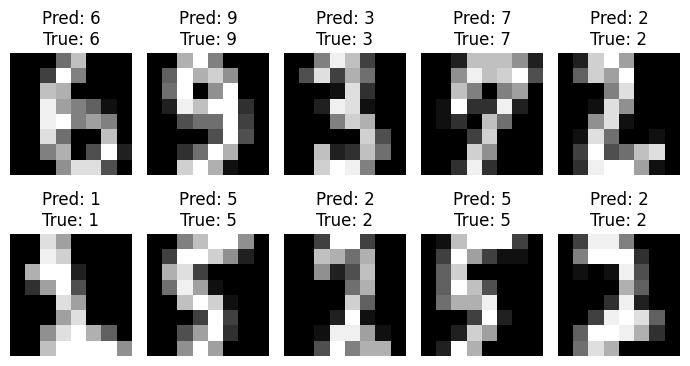

In [6]:
from MnistClassifier import MnistClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


def main():
    test_size = 0.3
    random_state=42
    
    data = load_digits()  # Load MNIST dataset
    X = data.data / 255
    Y = data.target

    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_size,random_state=random_state)  # Split dataset into train and test sets

    model = MnistClassifier(algorithm='rf')  # initialize one of three models: rf,cnn or nn.
    model.train(x_train, y_train)  # fit the train data
    y_pred = model.predict(x_test)  # predict test data
    acc_score = accuracy_score(y_test, y_pred)  # evaaluate metric
    print(f'Accuracy score for test data: {acc_score}')

    fig, axes = plt.subplots(2, 5, figsize=(7, 4))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(x_test[i].reshape(8, 8), cmap="gray")
        axes[i].set_title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



* Inference of Random Forest classifier shows us that model does not have problem with these digits. We did parametri search with Kfold method and it shows that 5 Fold had shown the best results (based on test data classification).


<center><b>Neural Network inference</b></center>


Feedforward Neural Network model is called
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_layer_1 (Dense)       (None, 128)               8320      
                                                                 
 dense_layer_2 (Dense)       (None, 256)               33024     
                                                                 
 dense_layer_5 (Dense)       (None, 128)               32896     
                                                                 
 dense_layer_6 (Dense)       (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 83,1

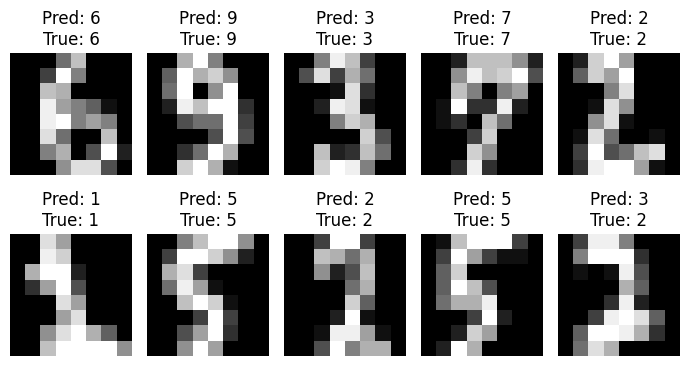

In [7]:
from MnistClassifier import MnistClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


def main():
    test_size = 0.3
    random_state=42
    
    data = load_digits()  # Load MNIST dataset
    X = data.data / 255
    Y = data.target

    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_size,random_state=random_state)  # Split dataset into train and test sets

    model = MnistClassifier(algorithm='nn')  # initialize one of three models: rf,cnn or nn.
    model.train(x_train, y_train)  # fit the train data
    y_pred = model.predict(x_test)  # predict test data
    acc_score = accuracy_score(y_test, y_pred)  # evaaluate metric
    print(f'Accuracy score for test data: {acc_score}')


    fig, axes = plt.subplots(2, 5, figsize=(7, 4))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(x_test[i].reshape(8, 8), cmap="gray")
        axes[i].set_title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



* Inference of Feed Forward Neural Network classifier shows us that model had a trouble with digit 2 (on the right bottom edge). This time we didnt do parameters search and fitted this model with Kfold parameters search.


<center><b>Convolution Neural Network inference</b></center>


Convolution Neural Network model is called
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 6, 6, 16)          160       
                                                                 
 maxpool_layer_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv_layer_2 (Conv2D)       (None, 4, 4, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_layer_2 (Dense)       (None, 256)               131328    
                

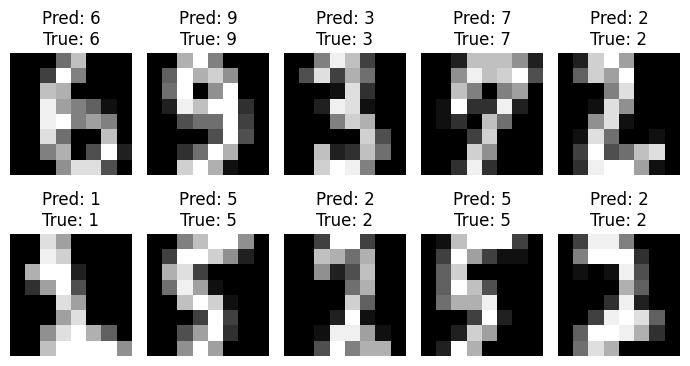

In [8]:
from MnistClassifier import MnistClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


def main():
    test_size = 0.3
    random_state=42
    
    data = load_digits()  # Load MNIST dataset
    X = data.data / 255
    Y = data.target

    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_size,random_state=random_state)  # Split dataset into train and test sets

    model = MnistClassifier(algorithm='cnn')  # initialize one of three models: rf,cnn or nn.
    model.train(x_train, y_train)  # fit the train data
    y_pred = model.predict(x_test)  # predict test data
    acc_score = accuracy_score(y_test, y_pred)  # evaaluate metric
    print(f'Accuracy score for test data: {acc_score}')


    fig, axes = plt.subplots(2, 5, figsize=(7, 4))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(x_test[i].reshape(8, 8), cmap="gray")
        axes[i].set_title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



* Inference of Convolution Neural Network classifier shows us that model did not have problem with those digits which were problem for other two classifiers.

<b>Key points from models inference:</b>

* The best result on accuracy has shown random forest model that showed 0.9920.

* The second was Convolution Neural Network with accuracy 0.9759. 

* The third is Feed Forward NN with accuracy 0.9700.  

* Although, Random Forest and Convolution Neural Network has shown the best results on those 10 digits on which were tested all 3 models.



<center>___________________________________________________________________________________________________________________________________________________</center>

**Additional inference of unknown method


In [9]:
from MnistClassifier import MnistClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


def main():
    test_size = 0.3
    random_state=42
    
    data = load_digits()  # Load MNIST dataset
    X = data.data / 255
    Y = data.target

    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_size,random_state=random_state)  # Split dataset into train and test sets

    model = MnistClassifier(algorithm='ss')  # initialize one of three models: rf,cnn or nn.
    model.train(x_train, y_train)  # fit the train data
    y_pred = model.predict(x_test)  # predict test data
    acc_score = accuracy_score(y_test, y_pred)  # evaaluate metric
    print(f'Accuracy score for test data: {acc_score}')


    fig, axes = plt.subplots(2, 5, figsize=(7, 4))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(x_test[i].reshape(8, 8), cmap="gray")
        axes[i].set_title(f"Pred: {y_pred[i]}\nTrue: {y_test[i]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



ValueError: Wrong algorithm was called. Use 'cnn', 'rf', or 'nn'.